## POS tagging using modified Viterbi

### Data Preparation

In [17]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [18]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [19]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [20]:
# Splitting into train and test
# Split data in to 95:5 for training: validation sets
train_set,validation_set=train_test_split(nltk_data,test_size=0.05,train_size=0.95,random_state = 101)

print(len(train_set))
print(len(validation_set))


3718
196


In [21]:
#Printing First few tagged sentences in training data set
print(train_set[1:5])

[[('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she', 'PRON'), ('did', 'VERB'), ('*T*-97', 'X'), ('was', 'VERB'), ('like', 'ADP'), ('*', 'X'), ('taking', 'VERB'), ('the', 'DET'), ('law', 'NOUN'), ('into', 'ADP'), ('your', 'PRON'), (

In [22]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95547

In [23]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [24]:
# vocabulary
V = set(tokens)
print(len(V))

12100


In [25]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [26]:
print(T)

{'CONJ', 'X', 'ADJ', 'DET', 'NOUN', 'ADP', '.', 'ADV', 'PRON', 'VERB', 'PRT', 'NUM'}


### POS Tagging Algorithm - HMM


We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

#### Emission Probablities

In [27]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [28]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities

In [29]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1]) # Count Number of times t1 has appeared
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2: # Number of times next index for t1 - next tag after t1 is t2
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)


In [30]:
# creating t x t transition matrix of tag
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [31]:
tags_matrix

array([[4.64900048e-04, 8.83310102e-03, 1.18084610e-01, 1.21338911e-01,
        3.49139929e-01, 5.25337048e-02, 3.48675027e-02, 5.53231053e-02,
        5.81125058e-02, 1.56671315e-01, 4.64900024e-03, 3.99814025e-02],
       [1.06619988e-02, 7.63844699e-02, 1.71865057e-02, 5.47422022e-02,
        6.23806491e-02, 1.42584339e-01, 1.63590074e-01, 2.49840859e-02,
        5.55378757e-02, 2.03851044e-01, 1.85232341e-01, 2.86441762e-03],
       [1.69714950e-02, 2.10907888e-02, 6.64030313e-02, 4.94315382e-03,
        6.99621022e-01, 7.82665983e-02, 6.39314577e-02, 4.77838190e-03,
        3.29543574e-04, 1.16987973e-02, 1.07101668e-02, 2.12555602e-02],
       [4.83033451e-04, 4.54051457e-02, 2.04323143e-01, 5.67564322e-03,
        6.38087213e-01, 9.53991059e-03, 1.79929957e-02, 1.24381110e-02,
        3.74350930e-03, 3.98502611e-02, 2.41516726e-04, 2.22195387e-02],
       [4.26659845e-02, 2.91751977e-02, 1.22477328e-02, 1.29423812e-02,
        2.63563901e-01, 1.76513597e-01, 2.40603983e-01, 1.70

In [32]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [33]:
tags_df

,CONJ,X,ADJ,DET,NOUN,ADP,.,ADV,PRON,VERB,PRT,NUM
CONJ,0.000465,0.008833,0.118085,0.121339,0.349140,0.052534,0.034868,0.055323,0.058113,0.156671,0.004649,0.039981
X,0.010662,0.076384,0.017187,0.054742,0.062381,0.142584,0.163590,0.024984,0.055538,0.203851,0.185232,0.002864
ADJ,0.016971,0.021091,0.066403,0.004943,0.699621,0.078267,0.063931,0.004778,0.000330,0.011699,0.010710,0.021256
DET,0.000483,0.045405,0.204323,0.005676,0.638087,0.009540,0.017993,0.012438,0.003744,0.039850,0.000242,0.022220
NOUN,0.042666,0.029175,0.012248,0.012942,0.263564,0.176514,0.240604,0.017074,0.004607,0.147667,0.043397,0.009542
ADP,0.000962,0.034427,0.107024,0.324709,0.320967,0.016893,0.039025,0.014006,0.070031,0.008340,0.001390,0.062226
.,0.057538,0.026971,0.043963,0.173335,0.222242,0.091342,0.093320,0.052324,0.066349,0.089095,0.002427,0.081003
ADV,0.006956,0.023186,0.129182,0.069891,0.031467,0.118582,0.137131,0.080490,0.014906,0.343491,0.014243,0.030474
PRON,0.005360,0.089969,0.073124,0.009954,0.210949,0.022971,0.040965,0.034074,0.007657,0.485452,0.013017,0.006508
VERB,0.005577,0.217506,0.064988,0.134392,0.110070,0.092022,0.034934,0.081952,0.035786,0.169249,0.030674,0.022851


##### Visualizing the DataFrame using Heat Map:

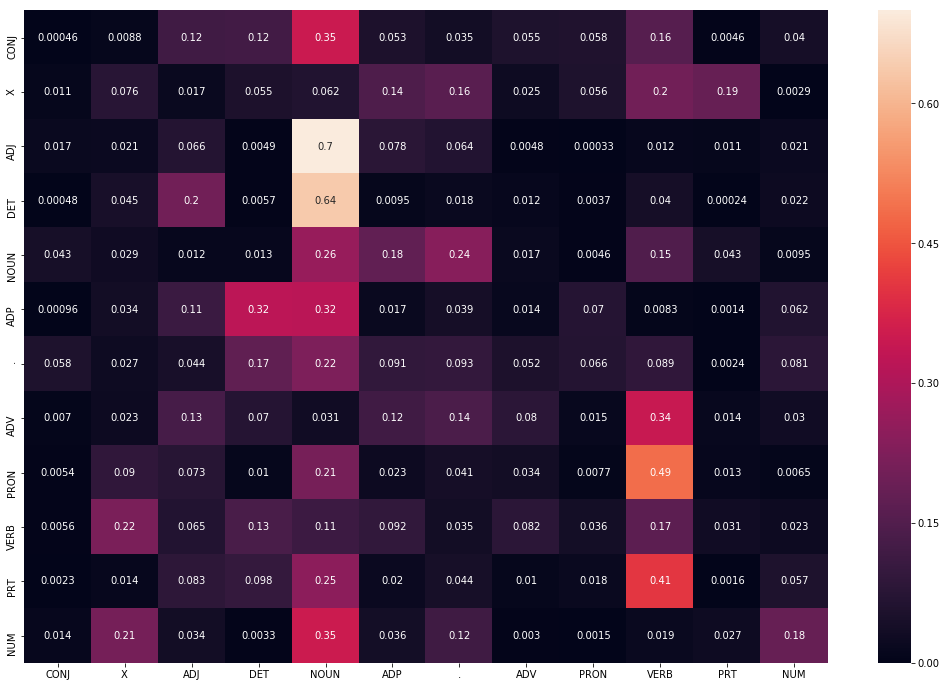

In [35]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [36]:
len(train_tagged_words)

95547

In [37]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating Unmodified Vanilla Viterbi POS


In [40]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(5)]

# list of sents
test_run = [validation_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [43]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  18.462382793426514


In [44]:

print(tagged_seq)
#print(test_run_base)

[('The', 'DET'), ('Contra', 'CONJ'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'CONJ'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'CONJ'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'CONJ'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'CONJ'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'CONJ'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'CONJ'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN

In [45]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [46]:
accuracy = len(check)/len(tagged_seq)

In [47]:
accuracy

0.8938053097345132

##### Checking for incorrect tagged sentence

In [48]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [49]:
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', 'CONJ'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'CONJ'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'CONJ'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'CONJ'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'CONJ'), ('rebel', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', 'CONJ'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', 'CONJ'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', 'CONJ'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'CONJ'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', 'CONJ'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications